In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import torch
import multiprocessing
from src.toolkit import compute_dissimilarity
import DSA
import similarity
import pickle
import numpy as np
import ipdb
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


### Load config

In [2]:
config = load_config("../config.yaml")

### Get dynamics

In [3]:
curves_frozen = []
curves_frozen_names = []
curves_unfrozen = []
curves_unfrozen_names = []
explained_variances_frozen = []
explained_variances_unfrozen = []
dissimilarities = {"within_unfrozen": {}, "within_frozen": {}, "across": []}
for activation in config["rnn"]["parameters"]["activations"]:
    for hidden_size in config["rnn"]["parameters"]["n_rnn"]:
        for lr in config["rnn"]["parameters"]["learning_rate"]:
            for freeze in config["rnn"]["parameters"]["freeze"]:
                curve, explained_variance = compute_dissimilarity(
                    activation, hidden_size, lr, freeze, "cpu"
                )
                if freeze:
                    curves_frozen.append(curve)
                    curves_frozen_names.append(
                        f"{activation}_{hidden_size}_{lr}"
                    )
                    explained_variances_frozen.append(explained_variance)
                else:
                    curves_unfrozen.append(curve)
                    curves_unfrozen_names.append(
                        f"{activation}_{hidden_size}_{lr}"
                    )
                    explained_variances_unfrozen.append(explained_variance)




In [4]:
curve.shape

(200, 512, 3)

### Explained Variance Analysis

#### Frozen models

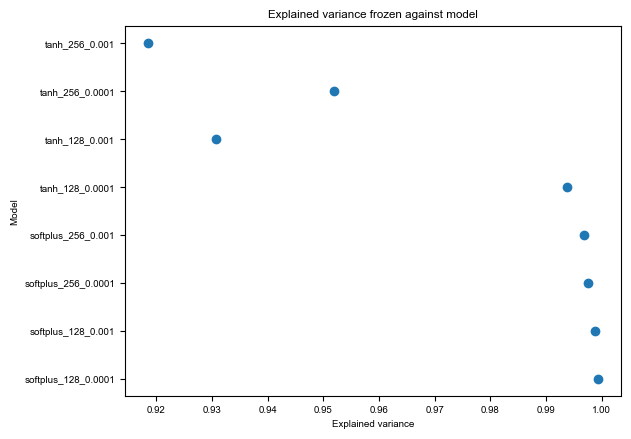

In [5]:
# plot explained variance frozen against curves frozen names
plt.figure()
plt.scatter(explained_variances_frozen, curves_frozen_names)
plt.xlabel("Explained variance")
plt.ylabel("Model")
plt.title("Explained variance frozen against model")
plt.show()

#### Unfrozen models

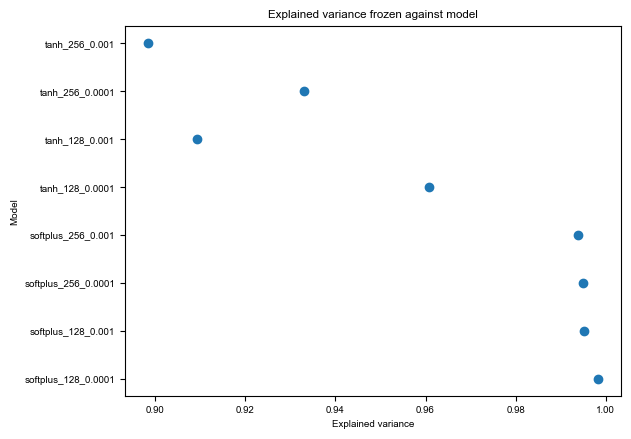

In [6]:
# plot explained variance frozen against curves frozen names
plt.figure()
plt.scatter(explained_variances_unfrozen, curves_unfrozen_names)
plt.xlabel("Explained variance")
plt.ylabel("Model")
plt.title("Explained variance frozen against model")
plt.show()

### Visualize curves frozen

In [7]:
curves_frozen[0][:,0,:].shape

(200, 3)

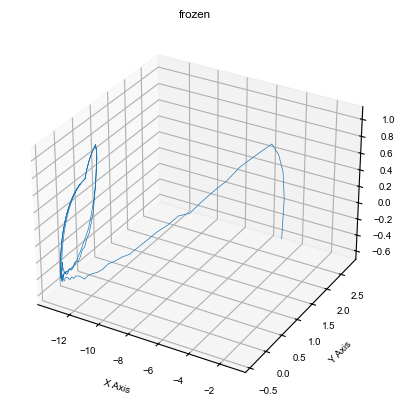

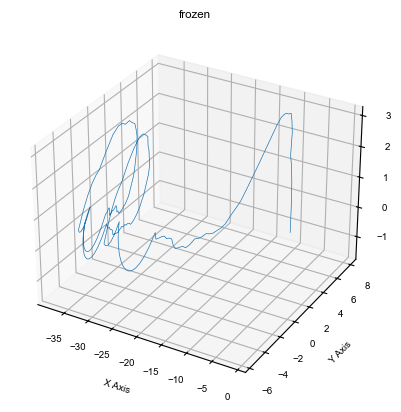

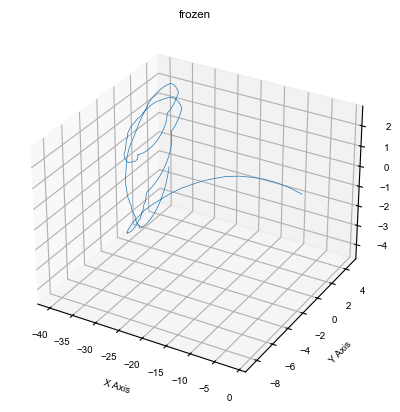

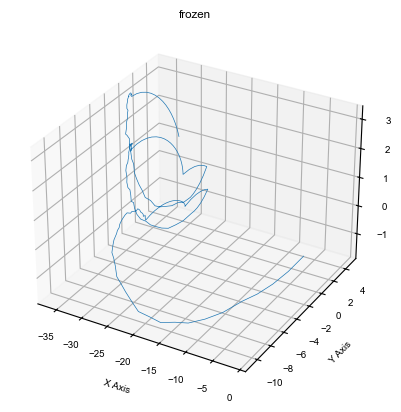

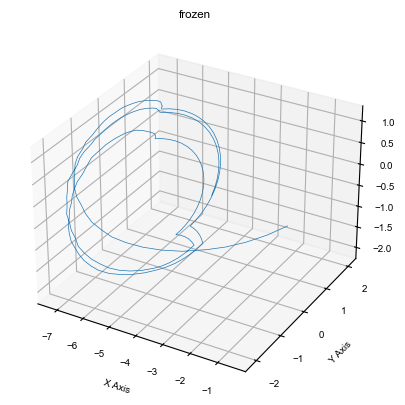

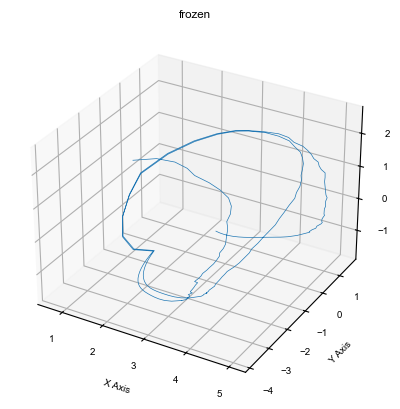

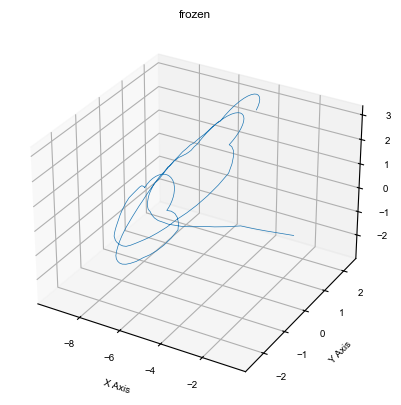

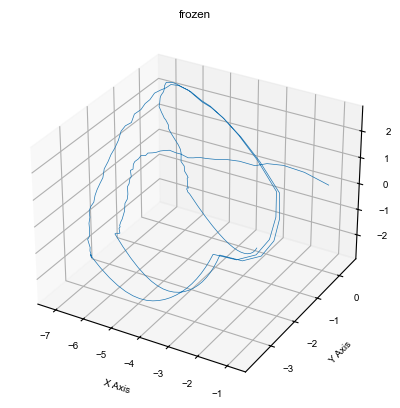

In [8]:
# for each curve in frozen, visualize the curve
visualize([curve[:,0,:] for curve in curves_frozen], f"frozen")

### Visualize curves unfrozen

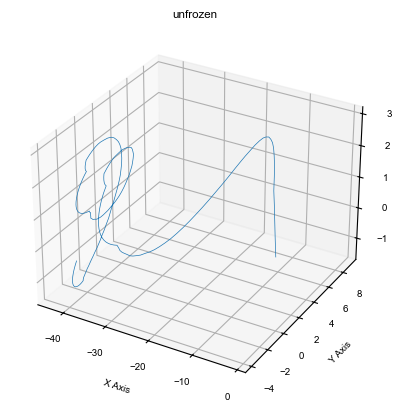

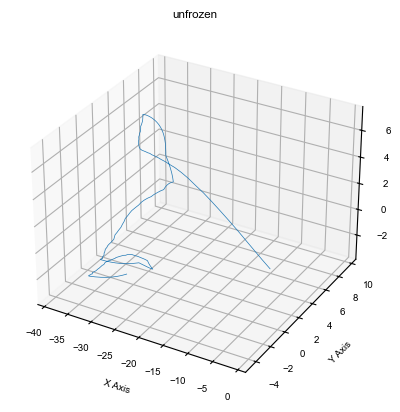

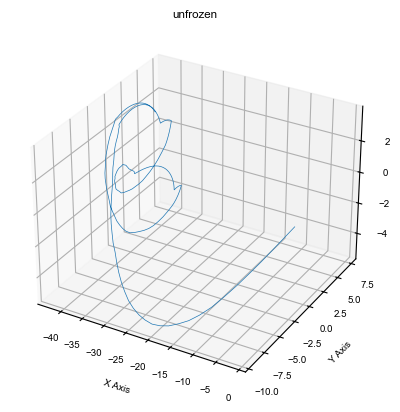

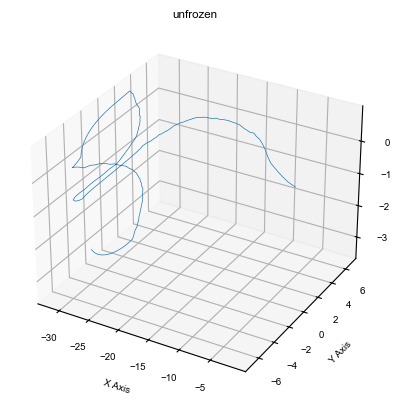

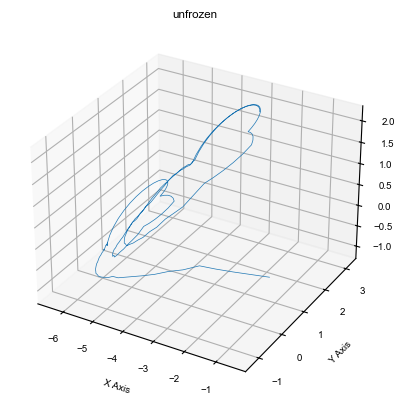

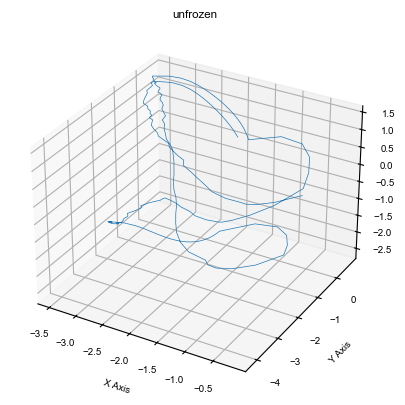

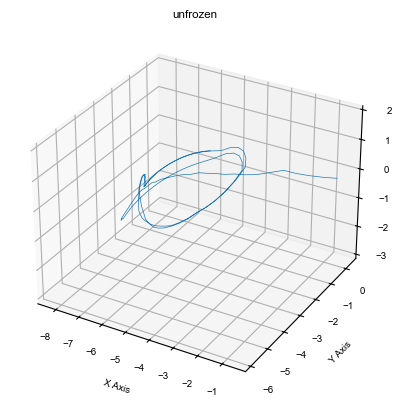

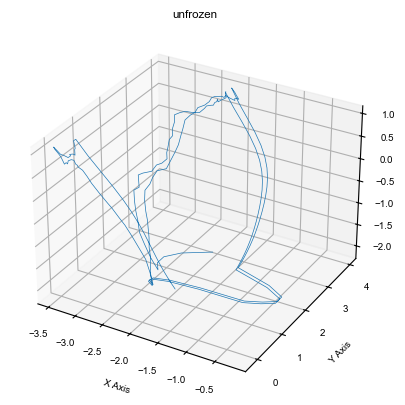

In [9]:
# for each curve in frozen, visualize the curve
visualize([curve[:,0,:] for curve in curves_unfrozen], f"unfrozen")

### Get dissimilarities

In [11]:
def measure_dissimilarities(group1, group2):
    cka_measure = similarity.make("measure.sim_metric.cka-angular-score")
    procrustes_measure = similarity.make("measure.netrep.procrustes-angular-score")
    dis_cka = np.empty((len(group1), len(group2)))
    dis_procrustes = np.empty((len(group1), len(group2)))
    for i, model1 in enumerate(group1):
        for j, model2 in enumerate(group2):
            dis_cka[i, j] = cka_measure(model1, model2)
            # test if nan otherwise replace by 1
            dis_procrustes[i, j] = procrustes_measure(model1, model2)
    dsa_comp = DSA.DSA(
        group1, group2,
        n_delays=config["dsa"]["n_delays"],
        rank=config["dsa"]["rank"],
        delay_interval=config["dsa"]["delay_interval"],
        verbose=True,
        iters=1000,
        lr=1e-2,
    )
    dis_dsa = 1-dsa_comp.fit_score()
    return {"cka":dis_cka, "procrusts":dis_procrustes, "dsa":dis_dsa}

# dissimilarity within_frozen
dissimilarities["within_frozen"]= measure_dissimilarities(curves_frozen, curves_frozen)

# dissimilarity within_unfrozen
dissimilarities["within_unfrozen"]= measure_dissimilarities(curves_unfrozen, curves_unfrozen)

# dissimilarity across
dissimilarities["across"]= measure_dissimilarities(curves_frozen, curves_unfrozen)

arccos score: 1.0000000128849382 nan 1.2884938227486487e-08
arccos score: 0.6349456100536905 0.8828582113139376 0.36505438994630945
arccos score: 0.7084776082770677 0.7834576370959058 0.29152239172293226
arccos score: 0.8934161466582686 0.4659032867100702 0.10658385334173137
arccos score: 0.43233841847863874 1.1237118458610174 0.5676615815213613
arccos score: 0.11726260477067818 1.4532633084771223 0.8827373952293218
arccos score: 0.1481750828643298 1.4220735972194696 0.8518249171356702
arccos score: 0.1349122974491861 1.4354713766275735 0.8650877025508139
arccos score: 0.6349456100536905 0.8828582113139376 0.36505438994630945
arccos score: 0.9999999820942932 0.00018923903857074315 1.7905706806153887e-08
arccos score: 0.9591176671379266 0.28692846172043573 0.040882332862073434
arccos score: 0.7424910282639299 0.7340148410233842 0.2575089717360701
arccos score: 0.2864306543928463 1.2802970124072053 0.7135693456071537
arccos score: 0.07497380789725117 1.4957521017725157 0.9250261921027488

In [12]:
dissimilarities['across']['cka']

array([[0.55463277, 0.51066558, 0.54140663, 0.50253456, 0.07913101,
        0.05656392, 0.06090641, 0.05397804],
       [0.8053318 , 0.5959229 , 0.76637459, 0.6441436 , 0.04509957,
        0.02248919, 0.03380637, 0.020274  ],
       [0.8190017 , 0.62604665, 0.79157215, 0.67667372, 0.04370984,
        0.02022732, 0.03264055, 0.01892915],
       [0.63178708, 0.5931587 , 0.62193242, 0.59127131, 0.09196492,
        0.07510205, 0.07496226, 0.06443949],
       [0.20310001, 0.2093554 , 0.22865079, 0.27538109, 0.27302988,
        0.12982723, 0.22612281, 0.14815492],
       [0.05148593, 0.04773193, 0.05450567, 0.06277501, 0.12027756,
        0.07084738, 0.14669045, 0.04879719],
       [0.05978445, 0.05293943, 0.06520699, 0.05479711, 0.18751824,
        0.04038953, 0.18572372, 0.04355933],
       [0.05505612, 0.05275396, 0.06164113, 0.06728774, 0.16831132,
        0.06388277, 0.17706524, 0.0583135 ]])

### Plot dissimilarities within and across groups

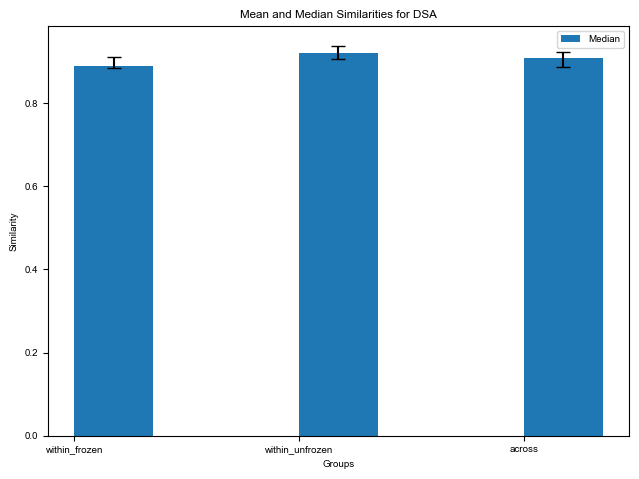

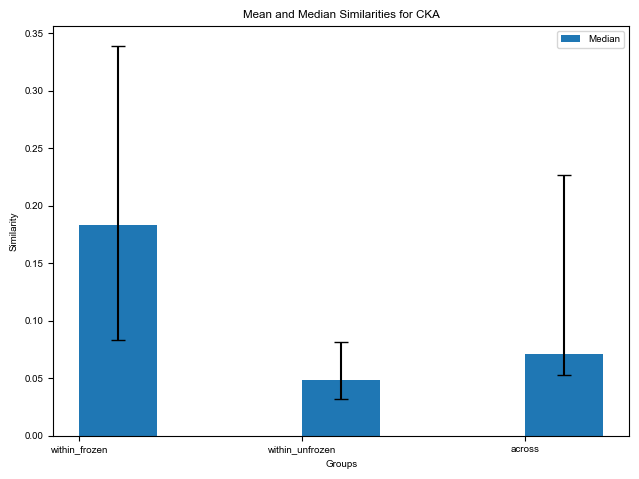

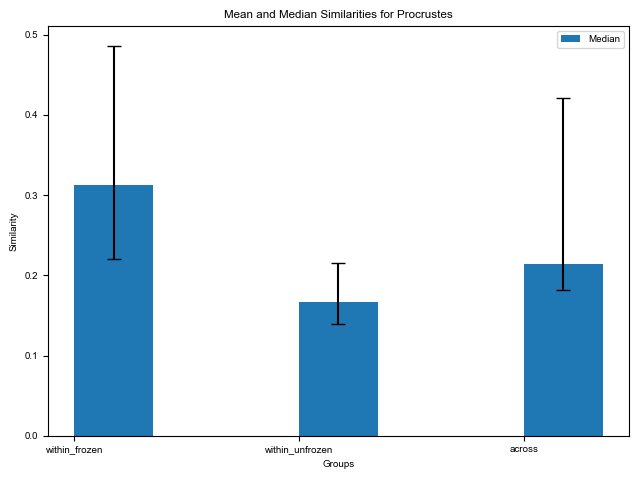

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `dissimilarities` is a dictionary with the computed dissimilarities


# Function to compute mean, median, and quartiles, excluding the diagonal for within-group comparisons
def compute_stats(dissimilarities, measure):
    stats = {}
    for group in ["within_frozen", "within_unfrozen", "across"]:
        dis_values = dissimilarities[group][measure]
        # # Mask the diagonal
        dis_values = dis_values[~np.eye(dis_values.shape[0], dtype=bool)]

        stats[group] = {
            "mean": np.mean(dis_values),
            "median": np.median(dis_values),
            "q1": np.percentile(dis_values, 25),
            "q3": np.percentile(dis_values, 75),
        }
    return stats


# Compute stats for each measure
stats_dsa = compute_stats(dissimilarities, "dsa")
stats_cka = compute_stats(dissimilarities, "cka")
stats_procrustes = compute_stats(dissimilarities, "procrusts")


# Function to plot the stats with error bars for quartiles
def plot_stats(stats, measure_name):
    groups = list(stats.keys())
    means = np.array([stats[group]["mean"] for group in groups])
    medians = np.array([stats[group]["median"] for group in groups])
    q1s = np.array([stats[group]["q1"] for group in groups])
    q3s = np.array([stats[group]["q3"] for group in groups])

    x = np.arange(len(groups))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects2 = ax.bar(
        x + width / 2,
        medians,
        width,
        label="Median",
        yerr=[medians - q1s, q3s - medians],
        capsize=5,
    )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Groups")
    ax.set_ylabel("Similarity")
    ax.set_title(f"Mean and Median Similarities for {measure_name}")
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.legend()

    fig.tight_layout()
    plt.show()


# Plot stats for each measure
plot_stats(stats_dsa, "DSA")
plot_stats(stats_cka, "CKA")
plot_stats(stats_procrustes, "Procrustes")

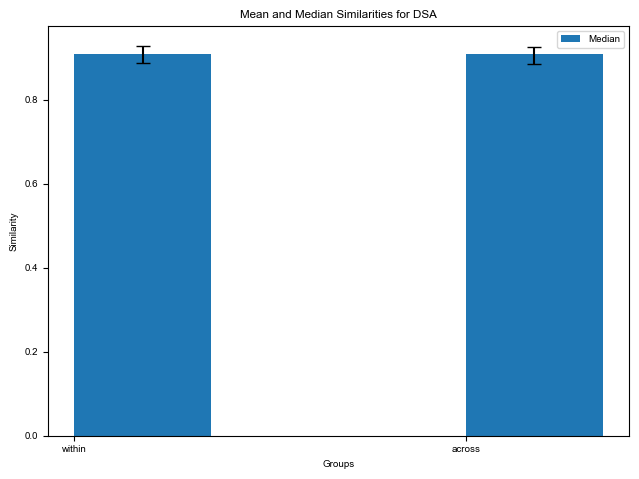

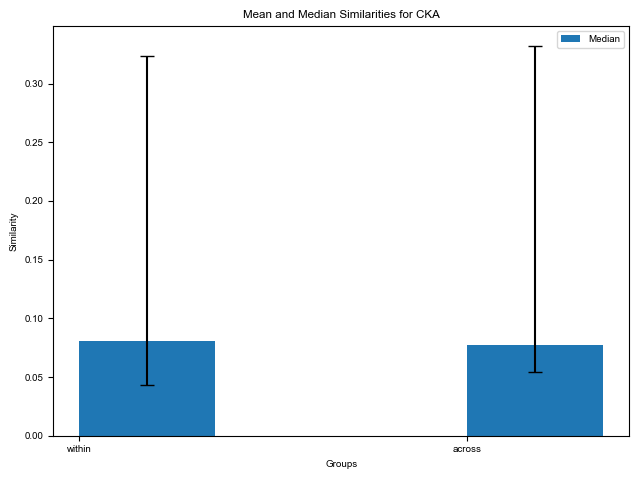

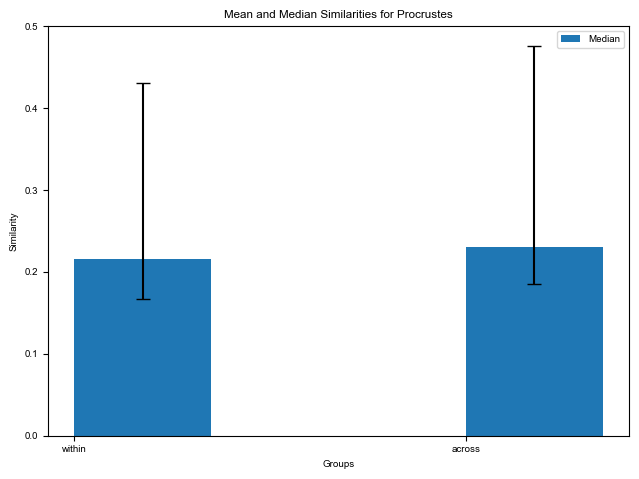

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `dissimilarities` is a dictionary with the computed dissimilarities


# Function to compute mean, median, and quartiles, excluding the diagonal for within-group comparisons
def compute_stats(dissimilarities, measure):
    stats = {}

    # Combine within_frozen and within_unfrozen into a single 'within' group
    dis_within = np.concatenate(
        [
            dissimilarities["within_frozen"][measure][
                ~np.eye(dissimilarities["within_frozen"][measure].shape[0], dtype=bool)
            ],
            dissimilarities["within_unfrozen"][measure][
                ~np.eye(
                    dissimilarities["within_unfrozen"][measure].shape[0], dtype=bool
                )
            ],
        ]
    )

    dis_across = dissimilarities["across"][measure]

    stats["within"] = {
        "mean": np.mean(dis_within),
        "median": np.median(dis_within),
        "q1": np.percentile(dis_within, 25),
        "q3": np.percentile(dis_within, 75),
    }

    stats["across"] = {
        "mean": np.mean(dis_across),
        "median": np.median(dis_across),
        "q1": np.percentile(dis_across, 25),
        "q3": np.percentile(dis_across, 75),
    }

    return stats


# Compute stats for each measure
stats_dsa = compute_stats(dissimilarities, "dsa")
stats_cka = compute_stats(dissimilarities, "cka")
stats_procrustes = compute_stats(dissimilarities, "procrusts")


# Function to plot the stats with error bars for quartiles
def plot_stats(stats, measure_name):
    groups = list(stats.keys())
    means = np.array([stats[group]["mean"] for group in groups])
    medians = np.array([stats[group]["median"] for group in groups])
    q1s = np.array([stats[group]["q1"] for group in groups])
    q3s = np.array([stats[group]["q3"] for group in groups])

    x = np.arange(len(groups))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects2 = ax.bar(
        x + width / 2,
        medians,
        width,
        label="Median",
        yerr=[medians - q1s, q3s - medians],
        capsize=5,
    )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Groups")
    ax.set_ylabel("Similarity")
    ax.set_title(f"Mean and Median Similarities for {measure_name}")
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.legend()

    fig.tight_layout()
    plt.show()


# Plot stats for each measure
plot_stats(stats_dsa, "DSA")
plot_stats(stats_cka, "CKA")
plot_stats(stats_procrustes, "Procrustes")


### Better results with higher dimensionality?

In [18]:
dimension = 5

In [19]:
curves_frozen = []
curves_frozen_names = []
curves_unfrozen = []
curves_unfrozen_names = []
explained_variances_frozen = []
explained_variances_unfrozen = []
dissimilarities = {"within_unfrozen": {}, "within_frozen": {}, "across": []}
for activation in config["rnn"]["parameters"]["activations"]:
    for hidden_size in config["rnn"]["parameters"]["n_rnn"]:
        for lr in config["rnn"]["parameters"]["learning_rate"]:
            for freeze in config["rnn"]["parameters"]["freeze"]:
                curve, explained_variance = compute_dissimilarity(
                    activation, hidden_size, lr, freeze, "cpu", n_components=dimension
                )
                if freeze:
                    curves_frozen.append(curve)
                    curves_frozen_names.append(
                        f"{activation}_{hidden_size}_{lr}"
                    )
                    explained_variances_frozen.append(explained_variance)
                else:
                    curves_unfrozen.append(curve)
                    curves_unfrozen_names.append(
                        f"{activation}_{hidden_size}_{lr}"
                    )
                    explained_variances_unfrozen.append(explained_variance)



In [20]:
curve.shape

(200, 512, 5)

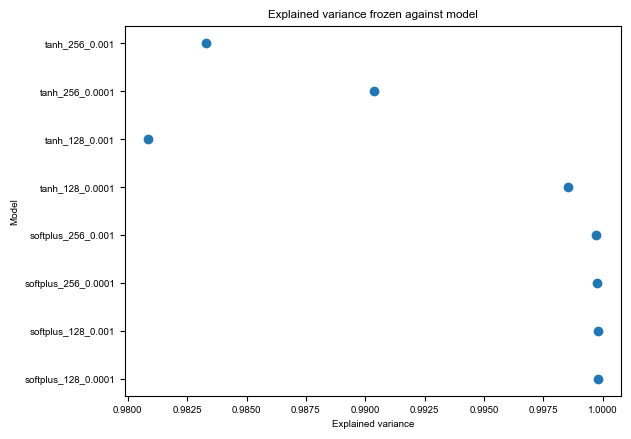

In [21]:
# plot explained variance frozen against curves frozen names
plt.figure()
plt.scatter(explained_variances_frozen, curves_frozen_names)
plt.xlabel("Explained variance")
plt.ylabel("Model")
plt.title("Explained variance frozen against model")
plt.show()

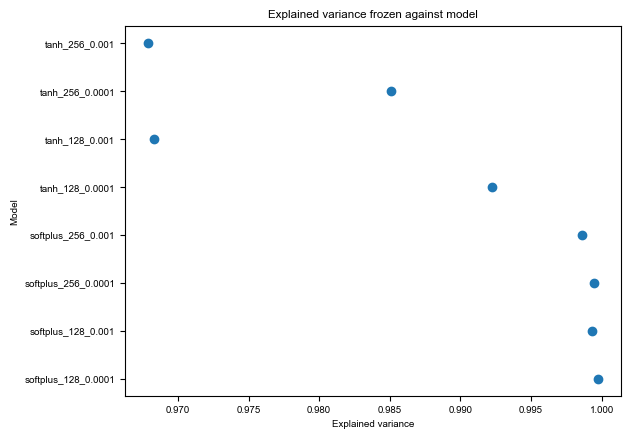

In [22]:
# plot explained variance frozen against curves frozen names
plt.figure()
plt.scatter(explained_variances_unfrozen, curves_unfrozen_names)
plt.xlabel("Explained variance")
plt.ylabel("Model")
plt.title("Explained variance frozen against model")
plt.show()

In [23]:
# dissimilarity within_frozen
dissimilarities["within_frozen"]= measure_dissimilarities(curves_frozen, curves_frozen)

# dissimilarity within_unfrozen
dissimilarities["within_unfrozen"]= measure_dissimilarities(curves_unfrozen, curves_unfrozen)

# dissimilarity across
dissimilarities["across"]= measure_dissimilarities(curves_frozen, curves_unfrozen)

arccos score: 0.9999999931818165 0.00011677485576966356 6.818183462264926e-09
arccos score: 0.6370408047102792 0.8801431521923606 0.36295919528972076
arccos score: 0.7121354207107843 0.7782610636016781 0.2878645792892157
arccos score: 0.8900989517023291 0.47323409315191706 0.10990104829767089
arccos score: 0.45227803262801825 1.1014784365650823 0.5477219673719818
arccos score: 0.1487314150301805 1.4215110314951482 0.8512685849698195
arccos score: 0.19619044769165273 1.3733249821385611 0.8038095523083473
arccos score: 0.2030631342840783 1.3663111044018985 0.7969368657159217
arccos score: 0.6370408047102792 0.8801431521923606 0.36295919528972076
arccos score: 0.999999962469649 0.00027397208355559364 3.753035104914204e-08
arccos score: 0.9633986719656135 0.2713920023440571 0.03660132803438654
arccos score: 0.7308554284735977 0.751221899980139 0.26914457152640225
arccos score: 0.30761912090152466 1.258106522314356 0.6923808790984753
arccos score: 0.08410672283306797 1.48659012597298 0.9158

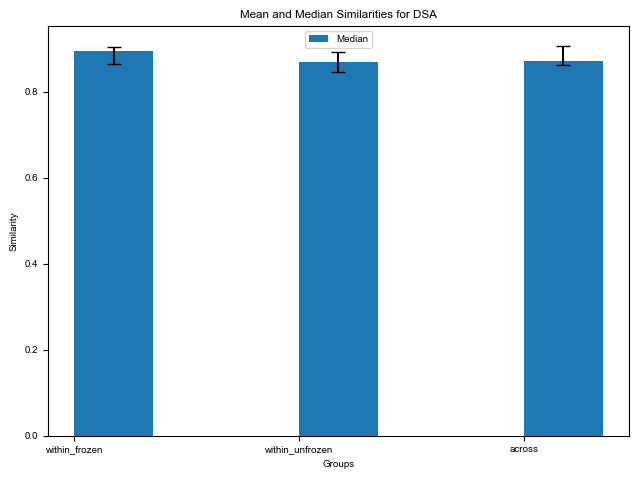

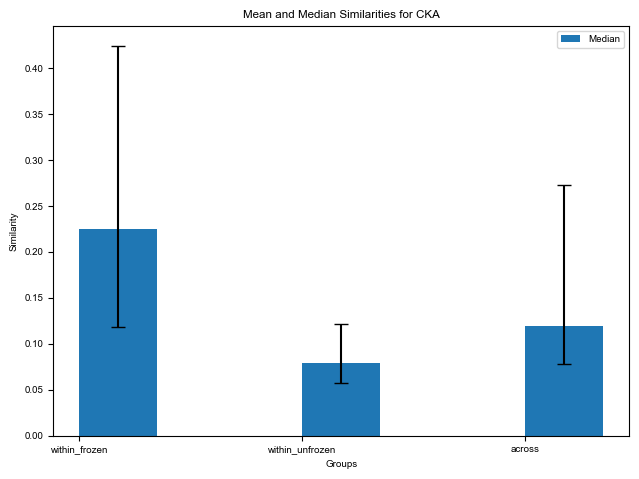

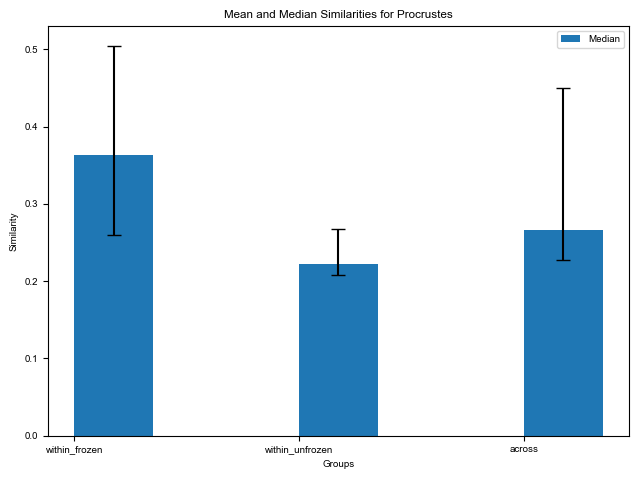

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `dissimilarities` is a dictionary with the computed dissimilarities


# Function to compute mean, median, and quartiles, excluding the diagonal for within-group comparisons
def compute_stats(dissimilarities, measure):
    stats = {}
    for group in ["within_frozen", "within_unfrozen", "across"]:
        dis_values = dissimilarities[group][measure]
        # # Mask the diagonal
        dis_values = dis_values[~np.eye(dis_values.shape[0], dtype=bool)]

        stats[group] = {
            "mean": np.mean(dis_values),
            "median": np.median(dis_values),
            "q1": np.percentile(dis_values, 25),
            "q3": np.percentile(dis_values, 75),
        }
    return stats


# Compute stats for each measure
stats_dsa = compute_stats(dissimilarities, "dsa")
stats_cka = compute_stats(dissimilarities, "cka")
stats_procrustes = compute_stats(dissimilarities, "procrusts")

# Function to plot the stats with error bars for quartiles
def plot_stats(stats, measure_name):
    groups = list(stats.keys())
    means = np.array([stats[group]["mean"] for group in groups])
    medians = np.array([stats[group]["median"] for group in groups])
    q1s = np.array([stats[group]["q1"] for group in groups])
    q3s = np.array([stats[group]["q3"] for group in groups])

    x = np.arange(len(groups))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects2 = ax.bar(
        x + width / 2,
        medians,
        width,
        label="Median",
        yerr=[medians - q1s, q3s - medians],
        capsize=5,
    )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Groups")
    ax.set_ylabel("Similarity")
    ax.set_title(f"Mean and Median Similarities for {measure_name}")
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.legend()

    fig.tight_layout()
    plt.show()


# Plot stats for each measure
plot_stats(stats_dsa, "DSA")
plot_stats(stats_cka, "CKA")
plot_stats(stats_procrustes, "Procrustes")

In [25]:
dimension = 10

In [26]:
curves_frozen = []
curves_frozen_names = []
curves_unfrozen = []
curves_unfrozen_names = []
explained_variances_frozen = []
explained_variances_unfrozen = []
dissimilarities = {"within_unfrozen": {}, "within_frozen": {}, "across": []}
for activation in config["rnn"]["parameters"]["activations"]:
    for hidden_size in config["rnn"]["parameters"]["n_rnn"]:
        for lr in config["rnn"]["parameters"]["learning_rate"]:
            for freeze in config["rnn"]["parameters"]["freeze"]:
                curve, explained_variance = compute_dissimilarity(
                    activation, hidden_size, lr, freeze, "cpu", n_components=dimension
                )
                if freeze:
                    curves_frozen.append(curve)
                    curves_frozen_names.append(
                        f"{activation}_{hidden_size}_{lr}"
                    )
                    explained_variances_frozen.append(explained_variance)
                else:
                    curves_unfrozen.append(curve)
                    curves_unfrozen_names.append(
                        f"{activation}_{hidden_size}_{lr}"
                    )
                    explained_variances_unfrozen.append(explained_variance)

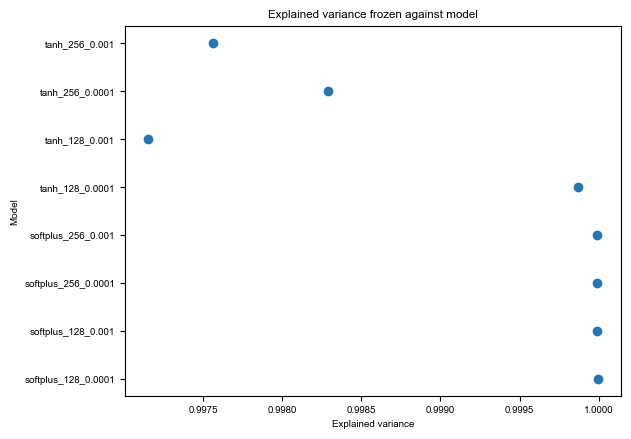

In [27]:
# plot explained variance frozen against curves frozen names
plt.figure()
plt.scatter(explained_variances_frozen, curves_frozen_names)
plt.xlabel("Explained variance")
plt.ylabel("Model")
plt.title("Explained variance frozen against model")
plt.show()

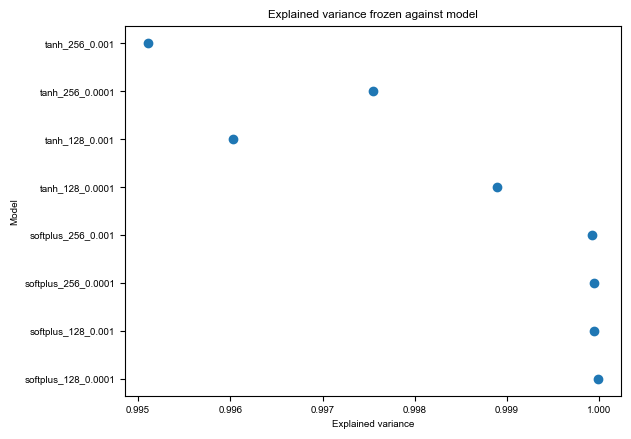

In [28]:
# plot explained variance frozen against curves frozen names
plt.figure()
plt.scatter(explained_variances_unfrozen, curves_unfrozen_names)
plt.xlabel("Explained variance")
plt.ylabel("Model")
plt.title("Explained variance frozen against model")
plt.show()

In [31]:
def measure_dissimilarities(group1, group2):
    cka_measure = similarity.make("measure.sim_metric.cka-angular-score")
    procrustes_measure = similarity.make("measure.netrep.procrustes-angular-score")
    dis_cka = np.empty((len(group1), len(group2)))
    dis_procrustes = np.empty((len(group1), len(group2)))
    for i, model1 in enumerate(group1):
        for j, model2 in enumerate(group2):
            dis_cka[i, j] = cka_measure(model1, model2)
            # test if nan otherwise replace by 1
            dis_procrustes[i, j] = procrustes_measure(model1, model2)
    dsa_comp = DSA.DSA(
        group1, group2,
        n_delays=100,
        rank=100,
        delay_interval=1,
        verbose=True,
        iters=1000,
        lr=1e-2,
    )
    dis_dsa = 1-dsa_comp.fit_score()
    return {"cka":dis_cka, "procrusts":dis_procrustes, "dsa":dis_dsa}

In [32]:
# dissimilarity within_frozen
dissimilarities["within_frozen"]= measure_dissimilarities(curves_frozen, curves_frozen)

# dissimilarity within_unfrozen
dissimilarities["within_unfrozen"]= measure_dissimilarities(curves_unfrozen, curves_unfrozen)

# dissimilarity across
dissimilarities["across"]= measure_dissimilarities(curves_frozen, curves_unfrozen)

arccos score: 1.0000000196637389 nan 1.9663738859421187e-08
arccos score: 0.6361223139034974 0.881334127027075 0.3638776860965026
arccos score: 0.7129683601012635 0.7770738963526608 0.2870316398987365
arccos score: 0.889967165529867 0.47352316386274057 0.11003283447013301
arccos score: 0.45352223697903726 1.1000829020172078 0.5464777630209627
arccos score: 0.1572662060222264 1.412874529111461 0.8427337939777736
arccos score: 0.20496002806740132 1.3643734586375424 0.7950399719325987
arccos score: 0.20855181454575644 1.3607023465137031 0.7914481854542436
arccos score: 0.6361223139034974 0.881334127027075 0.3638776860965026
arccos score: 0.9999999775503245 0.00021189466975811392 2.244967545195209e-08
arccos score: 0.9616341727844521 0.2778981513004728 0.03836582721554793
arccos score: 0.7287946857654335 0.7542362999195865 0.2712053142345665
arccos score: 0.30804926607107586 1.257654423216275 0.6919507339289241
arccos score: 0.09459400470127421 1.4760606794111228 0.9054059952987258
arccos 

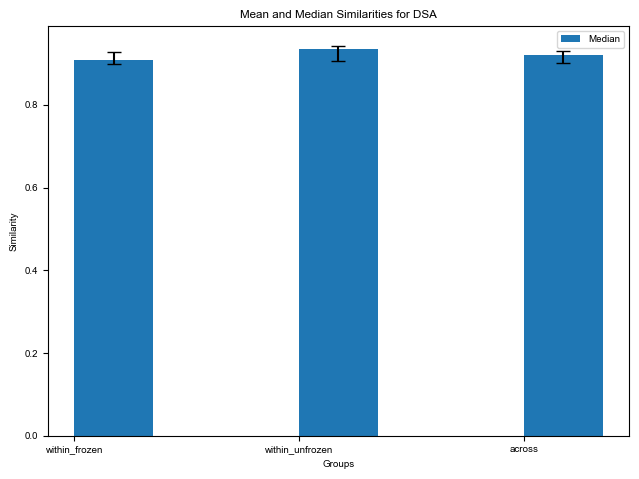

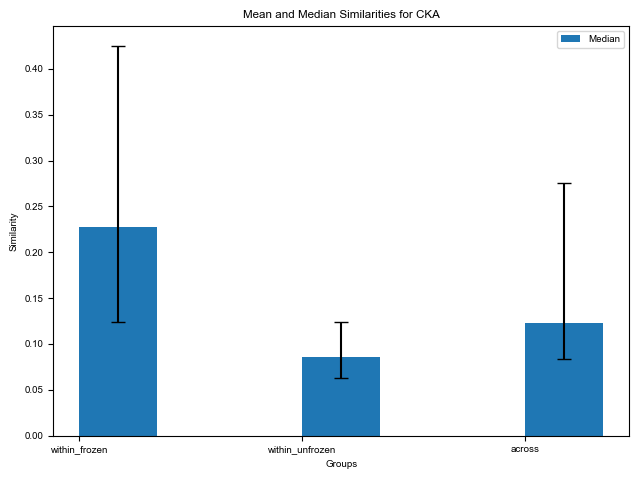

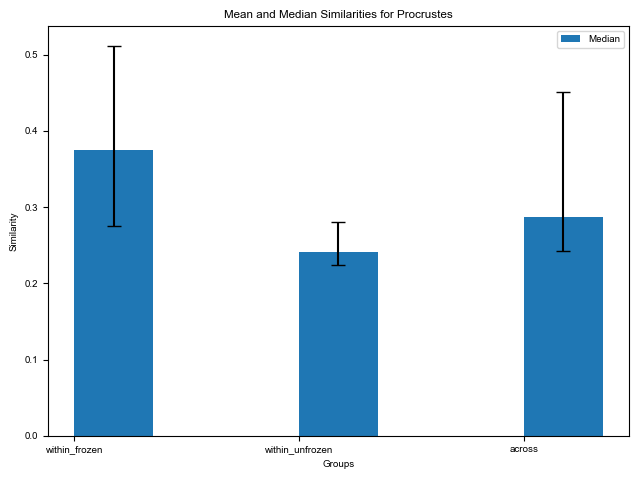

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `dissimilarities` is a dictionary with the computed dissimilarities


# Function to compute mean, median, and quartiles, excluding the diagonal for within-group comparisons
def compute_stats(dissimilarities, measure):
    stats = {}
    for group in ["within_frozen", "within_unfrozen", "across"]:
        dis_values = dissimilarities[group][measure]
        # # Mask the diagonal
        dis_values = dis_values[~np.eye(dis_values.shape[0], dtype=bool)]

        stats[group] = {
            "mean": np.mean(dis_values),
            "median": np.median(dis_values),
            "q1": np.percentile(dis_values, 25),
            "q3": np.percentile(dis_values, 75),
        }
    return stats


# Compute stats for each measure
stats_dsa = compute_stats(dissimilarities, "dsa")
stats_cka = compute_stats(dissimilarities, "cka")
stats_procrustes = compute_stats(dissimilarities, "procrusts")

# Function to plot the stats with error bars for quartiles
def plot_stats(stats, measure_name):
    groups = list(stats.keys())
    means = np.array([stats[group]["mean"] for group in groups])
    medians = np.array([stats[group]["median"] for group in groups])
    q1s = np.array([stats[group]["q1"] for group in groups])
    q3s = np.array([stats[group]["q3"] for group in groups])

    x = np.arange(len(groups))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects2 = ax.bar(
        x + width / 2,
        medians,
        width,
        label="Median",
        yerr=[medians - q1s, q3s - medians],
        capsize=5,
    )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Groups")
    ax.set_ylabel("Similarity")
    ax.set_title(f"Mean and Median Similarities for {measure_name}")
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.legend()

    fig.tight_layout()
    plt.show()


# Plot stats for each measure
plot_stats(stats_dsa, "DSA")
plot_stats(stats_cka, "CKA")
plot_stats(stats_procrustes, "Procrustes")